# Introduction

The Future Sales competition is the final assesment in the 'How to win a Data Science' course in the Advanced Machine Learning specialisation from HSE University, Moscow. The aim is to predict the monthly sales of items in specific shops, given historical data. The sale counts are clipped between 0 and 20.

In [4]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")

# /kaggle/input 내의 모든 파일의 경로 출력
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/competitive-data-science-predict-future-sales/items.csv
/kaggle/input/competitive-data-science-predict-future-sales/sample_submission.csv
/kaggle/input/competitive-data-science-predict-future-sales/item_categories.csv
/kaggle/input/competitive-data-science-predict-future-sales/sales_train.csv
/kaggle/input/competitive-data-science-predict-future-sales/shops.csv
/kaggle/input/competitive-data-science-predict-future-sales/test.csv


# Load Data

In [5]:
# load data
items=pd.read_csv("/kaggle/input/competitive-data-science-predict-future-sales/items.csv")
shops=pd.read_csv("/kaggle/input/competitive-data-science-predict-future-sales/shops.csv")
cats=pd.read_csv("/kaggle/input/competitive-data-science-predict-future-sales/item_categories.csv")
train=pd.read_csv("/kaggle/input/competitive-data-science-predict-future-sales/sales_train.csv")
test=pd.read_csv("/kaggle/input/competitive-data-science-predict-future-sales/test.csv")

# 1. Data Cleaning

We'll remove outliers, clean up some of the raw data and add some new variables to it.

# Remove outliers

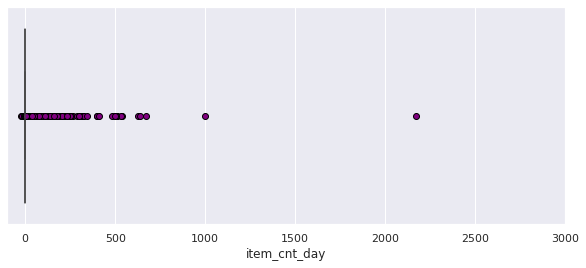

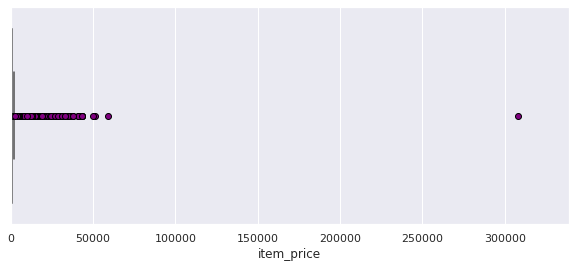

In [6]:
plt.figure(figsize=(10,4))   #그림 사이즈 지정
plt.xlim(-100, 3000)    # X 값 범위
flierprops = dict(marker='o', markerfacecolor='purple', markersize=6,
                  linestyle='none', markeredgecolor='black')
#포인터 설정

sns.boxplot(x=train.item_cnt_day, flierprops=flierprops)   
# x 를 train의 itm_cnt로 하는 박스플롯 
#flierprops는 위에 설정한대로


#train.item_price 박스 플롯 추가
plt.figure(figsize=(10,4))
plt.xlim(train.item_price.min(), train.item_price.max()*1.1)
sns.boxplot(x=train.item_price, flierprops=flierprops)

We'll remove the obvious outliers in the dataset - the items that sold more than 1000 in one day and the item with price greater than 300,000.

In [7]:
train = train[(train.item_price < 300000 )& (train.item_cnt_day < 1000)]
# 아웃라이어 값 제거

Remove any rows from train where item price is negative - these could be refunds. Also make zero and item_cnt_day values less than one, to remove negative values.

In [8]:
train = train[train.item_price > 0].reset_index(drop = True)
# 가격이 음수인 데이터 제거
train.loc[train.item_cnt_day < 1, "item_cnt_day"] = 0
# day가 음수인것도 0으로 만듬

# Cleaning Shop Data

Several of the shops look like duplicates of each other. This could be down to shops re-opening or possibly moving store location on the same street or shopping centre.

In [9]:
# Якутск Орджоникидзе, 56
train.loc[train.shop_id == 0, 'shop_id'] = 57
test.loc[test.shop_id == 0, 'shop_id'] = 57
# Якутск ТЦ "Центральный"
train.loc[train.shop_id == 1, 'shop_id'] = 58
test.loc[test.shop_id == 1, 'shop_id'] = 58
# Жуковский ул. Чкалова 39м²
train.loc[train.shop_id == 10, 'shop_id'] = 11
test.loc[test.shop_id == 10, 'shop_id'] = 11

# 0 ->  57
# 1 -> 58
# 10 -> 11
# 로 값 변경

Clean up some shop names and add 'city' and 'category' to shops df.

In [10]:
shops.loc[ shops.shop_name == 'Сергиев Посад ТЦ "7Я"',"shop_name" ] = 'СергиевПосад ТЦ "7Я"'
shops["city"] = shops.shop_name.str.split(" ").map( lambda x: x[0] )
shops["category"] = shops.shop_name.str.split(" ").map( lambda x: x[1] )
shops.loc[shops.city == "!Якутск", "city"] = "Якутск"

Only keep shop category if there are 5 or more shops of that category, the rest are grouped as "other".

In [11]:
category = []
for cat in shops.category.unique():
    if len(shops[shops.category == cat]) >= 5:
        category.append(cat)
shops.category = shops.category.apply( lambda x: x if (x in category) else "other" )

In [12]:
from sklearn.preprocessing import LabelEncoder
shops["shop_category"] = LabelEncoder().fit_transform( shops.category )
shops["shop_city"] = LabelEncoder().fit_transform( shops.city )
shops = shops[["shop_id", "shop_category", "shop_city"]]

# Cleaning Item Category Data

In [13]:
cats["type_code"] = cats.item_category_name.apply( lambda x: x.split(" ")[0] ).astype(str)
cats.loc[ (cats.type_code == "Игровые")| (cats.type_code == "Аксессуары"), "category" ] = "Игры"

In [14]:
category = []
for cat in cats.type_code.unique():
    if len(cats[cats.type_code == cat]) >= 5: 
        category.append( cat )
cats.type_code = cats.type_code.apply(lambda x: x if (x in category) else "etc")

In [15]:
cats.type_code = LabelEncoder().fit_transform(cats.type_code)
cats["split"] = cats.item_category_name.apply(lambda x: x.split("-"))
cats["subtype"] = cats.split.apply(lambda x: x[1].strip() if len(x) > 1 else x[0].strip())
cats["subtype_code"] = LabelEncoder().fit_transform( cats["subtype"] )
cats = cats[["item_category_id", "subtype_code", "type_code"]]

# Cleaning Item Data

In [16]:
import re
def name_correction(x):
    x = x.lower() # all letters lower case
    x = x.partition('[')[0] # partition by square brackets
    x = x.partition('(')[0] # partition by curly brackets
    x = re.sub('[^A-Za-z0-9А-Яа-я]+', ' ', x) # remove special characters
    x = x.replace('  ', ' ') # replace double spaces with single spaces
    x = x.strip() # remove leading and trailing white space
    return x

Clean item names.

In [17]:
# split item names by first bracket
items["name1"], items["name2"] = items.item_name.str.split("[", 1).str
items["name1"], items["name3"] = items.item_name.str.split("(", 1).str

# replace special characters and turn to lower case
items["name2"] = items.name2.str.replace('[^A-Za-z0-9А-Яа-я]+', " ").str.lower()
items["name3"] = items.name3.str.replace('[^A-Za-z0-9А-Яа-я]+', " ").str.lower()

# fill nulls with '0'
items = items.fillna('0')

items["item_name"] = items["item_name"].apply(lambda x: name_correction(x))

# return all characters except the last if name 2 is not "0" - the closing bracket
items.name2 = items.name2.apply( lambda x: x[:-1] if x !="0" else "0")

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  This is separate from the ipykernel package so we can avoid doing imports until


Clean item type

In [18]:
items["type"] = items.name2.apply(lambda x: x[0:8] if x.split(" ")[0] == "xbox" else x.split(" ")[0] )
items.loc[(items.type == "x360") | (items.type == "xbox360") | (items.type == "xbox 360") ,"type"] = "xbox 360"
items.loc[ items.type == "", "type"] = "mac"
items.type = items.type.apply( lambda x: x.replace(" ", "") )
items.loc[ (items.type == 'pc' )| (items.type == 'pс') | (items.type == "pc"), "type" ] = "pc"
items.loc[ items.type == 'рs3' , "type"] = "ps3"

In [19]:
group_sum = items.groupby(["type"]).agg({"item_id": "count"})
group_sum = group_sum.reset_index()
drop_cols = []
for cat in group_sum.type.unique():
    if group_sum.loc[(group_sum.type == cat), "item_id"].values[0] <40:
        drop_cols.append(cat)
items.name2 = items.name2.apply( lambda x: "other" if (x in drop_cols) else x )
items = items.drop(["type"], axis = 1)

In [20]:
items.name2 = LabelEncoder().fit_transform(items.name2)
items.name3 = LabelEncoder().fit_transform(items.name3)

items.drop(["item_name", "name1"],axis = 1, inplace= True)
items.head()

,item_id,item_category_id,name2,name3
0,0,40,4,1331
1,1,76,64,42
2,2,40,4,1011
3,3,40,4,1010
4,4,40,4,1572


# Preprocessing

Create a matrix df with every combination of month, shop and item in order of increasing month. Item_cnt_day is summed into an item_cnt_month.

In [21]:
from itertools import product
import time
ts = time.time()
matrix = []
cols  = ["date_block_num", "shop_id", "item_id"]
for i in range(34):
    sales = train[train.date_block_num == i]
    matrix.append( np.array(list( product( [i], sales.shop_id.unique(), sales.item_id.unique() ) ), dtype = np.int16) )

matrix = pd.DataFrame( np.vstack(matrix), columns = cols )
matrix["date_block_num"] = matrix["date_block_num"].astype(np.int8)
matrix["shop_id"] = matrix["shop_id"].astype(np.int8)
matrix["item_id"] = matrix["item_id"].astype(np.int16)
matrix.sort_values( cols, inplace = True )
time.time()- ts

23.480090379714966

In [22]:
# add revenue to train df
train["revenue"] = train["item_cnt_day"] * train["item_price"]

In [23]:
ts = time.time()
group = train.groupby( ["date_block_num", "shop_id", "item_id"] ).agg( {"item_cnt_day": ["sum"]} )
group.columns = ["item_cnt_month"]
group.reset_index( inplace = True)
matrix = pd.merge( matrix, group, on = cols, how = "left" )
matrix["item_cnt_month"] = matrix["item_cnt_month"].fillna(0).astype(np.float16)
time.time() - ts

6.925291061401367

Create a test set for month 34.

In [24]:
test["date_block_num"] = 34
test["date_block_num"] = test["date_block_num"].astype(np.int8)
test["shop_id"] = test.shop_id.astype(np.int8)
test["item_id"] = test.item_id.astype(np.int16)

Concatenate train and test sets.

In [25]:
ts = time.time()

matrix = pd.concat([matrix, test.drop(["ID"],axis = 1)], ignore_index=True, sort=False, keys=cols)
matrix.fillna( 0, inplace = True )
time.time() - ts

0.06029701232910156

Add shop, items and categories data onto matrix df.

In [26]:
ts = time.time()
matrix = pd.merge( matrix, shops, on = ["shop_id"], how = "left" )
matrix = pd.merge(matrix, items, on = ["item_id"], how = "left")
matrix = pd.merge( matrix, cats, on = ["item_category_id"], how = "left" )
matrix["shop_city"] = matrix["shop_city"].astype(np.int8)
matrix["shop_category"] = matrix["shop_category"].astype(np.int8)
matrix["item_category_id"] = matrix["item_category_id"].astype(np.int8)
matrix["subtype_code"] = matrix["subtype_code"].astype(np.int8)
matrix["name2"] = matrix["name2"].astype(np.int8)
matrix["name3"] = matrix["name3"].astype(np.int16)
matrix["type_code"] = matrix["type_code"].astype(np.int8)
time.time() - ts

4.888315200805664

Feature Engineering

* Add lag features to matrix df.

In [27]:
# Define a lag feature function
def lag_feature( df,lags, cols ):
    for col in cols:
        print(col)
        tmp = df[["date_block_num", "shop_id","item_id",col ]]
        for i in lags:
            shifted = tmp.copy()
            shifted.columns = ["date_block_num", "shop_id", "item_id", col + "_lag_"+str(i)]
            shifted.date_block_num = shifted.date_block_num + i
            df = pd.merge(df, shifted, on=['date_block_num','shop_id','item_id'], how='left')
    return df

Add item_cnt_month lag features.

In [28]:
ts = time.time()
matrix = lag_feature( matrix, [1,2,3], ["item_cnt_month"] )
time.time() - ts

item_cnt_month


27.098473072052002

Add the previous month's average item_cnt.

In [29]:
ts = time.time()
group = matrix.groupby( ["date_block_num"] ).agg({"item_cnt_month" : ["mean"]})
group.columns = ["date_avg_item_cnt"]
group.reset_index(inplace = True)

matrix = pd.merge(matrix, group, on = ["date_block_num"], how = "left")
matrix.date_avg_item_cnt = matrix["date_avg_item_cnt"].astype(np.float16)
matrix = lag_feature( matrix, [1], ["date_avg_item_cnt"] )
matrix.drop( ["date_avg_item_cnt"], axis = 1, inplace = True )
time.time() - ts

date_avg_item_cnt


15.529134273529053

Add lag values of item_cnt_month for month / item_id.

In [30]:
ts = time.time()
group = matrix.groupby(['date_block_num', 'item_id']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_item_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num','item_id'], how='left')
matrix.date_item_avg_item_cnt = matrix['date_item_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1,2,3], ['date_item_avg_item_cnt'])
matrix.drop(['date_item_avg_item_cnt'], axis=1, inplace=True)
time.time() - ts

date_item_avg_item_cnt


37.312939405441284

Add lag values for item_cnt_month for every month / shop combination.

In [31]:
ts = time.time()
group = matrix.groupby( ["date_block_num","shop_id"] ).agg({"item_cnt_month" : ["mean"]})
group.columns = ["date_shop_avg_item_cnt"]
group.reset_index(inplace = True)

matrix = pd.merge(matrix, group, on = ["date_block_num","shop_id"], how = "left")
matrix.date_avg_item_cnt = matrix["date_shop_avg_item_cnt"].astype(np.float16)
matrix = lag_feature( matrix, [1,2,3], ["date_shop_avg_item_cnt"] )
matrix.drop( ["date_shop_avg_item_cnt"], axis = 1, inplace = True )
time.time() - ts

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  import sys


date_shop_avg_item_cnt


39.810373306274414

Add lag values for item_cnt_month for month/shop/item.

In [32]:
ts = time.time()
group = matrix.groupby( ["date_block_num","shop_id","item_id"] ).agg({"item_cnt_month" : ["mean"]})
group.columns = ["date_shop_item_avg_item_cnt"]
group.reset_index(inplace = True)

matrix = pd.merge(matrix, group, on = ["date_block_num","shop_id","item_id"], how = "left")
matrix.date_avg_item_cnt = matrix["date_shop_item_avg_item_cnt"].astype(np.float16)
matrix = lag_feature( matrix, [1,2,3], ["date_shop_item_avg_item_cnt"] )
matrix.drop( ["date_shop_item_avg_item_cnt"], axis = 1, inplace = True )
time.time() - ts

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  import sys


date_shop_item_avg_item_cnt


57.74555253982544

Add lag values for item_cnt_month for month/shop/item subtype.

In [33]:
ts = time.time()
group = matrix.groupby(['date_block_num', 'shop_id', 'subtype_code']).agg({'item_cnt_month': ['mean']})
group.columns = ['date_shop_subtype_avg_item_cnt']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'shop_id', 'subtype_code'], how='left')
matrix.date_shop_subtype_avg_item_cnt = matrix['date_shop_subtype_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], ['date_shop_subtype_avg_item_cnt'])
matrix.drop(['date_shop_subtype_avg_item_cnt'], axis=1, inplace=True)
time.time() - ts

date_shop_subtype_avg_item_cnt


22.250345945358276

Add lag values for item_cnt_month for month/city.

In [34]:
ts = time.time()
group = matrix.groupby(['date_block_num', 'shop_city']).agg({'item_cnt_month': ['mean']})
group.columns = ['date_city_avg_item_cnt']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', "shop_city"], how='left')
matrix.date_city_avg_item_cnt = matrix['date_city_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], ['date_city_avg_item_cnt'])
matrix.drop(['date_city_avg_item_cnt'], axis=1, inplace=True)
time.time() - ts

date_city_avg_item_cnt


22.4897620677948

Add lag values for item_cnt_month for month/city/item.

In [35]:
ts = time.time()
group = matrix.groupby(['date_block_num', 'item_id', 'shop_city']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_item_city_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'item_id', 'shop_city'], how='left')
matrix.date_item_city_avg_item_cnt = matrix['date_item_city_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], ['date_item_city_avg_item_cnt'])
matrix.drop(['date_item_city_avg_item_cnt'], axis=1, inplace=True)
time.time() - ts

date_item_city_avg_item_cnt


34.923664569854736

* Add average item price on to matix df. 
* Add lag values of item price per month.
* Add delta price values - how current month average pirce relates to global average.

In [36]:
ts = time.time()
group = train.groupby( ["item_id"] ).agg({"item_price": ["mean"]})
group.columns = ["item_avg_item_price"]
group.reset_index(inplace = True)

matrix = matrix.merge( group, on = ["item_id"], how = "left" )
matrix["item_avg_item_price"] = matrix.item_avg_item_price.astype(np.float16)


group = train.groupby( ["date_block_num","item_id"] ).agg( {"item_price": ["mean"]} )
group.columns = ["date_item_avg_item_price"]
group.reset_index(inplace = True)

matrix = matrix.merge(group, on = ["date_block_num","item_id"], how = "left")
matrix["date_item_avg_item_price"] = matrix.date_item_avg_item_price.astype(np.float16)
lags = [1, 2, 3]
matrix = lag_feature( matrix, lags, ["date_item_avg_item_price"] )
for i in lags:
    matrix["delta_price_lag_" + str(i) ] = (matrix["date_item_avg_item_price_lag_" + str(i)]- matrix["item_avg_item_price"] )/ matrix["item_avg_item_price"]

def select_trends(row) :
    for i in lags:
        if row["delta_price_lag_" + str(i)]:
            return row["delta_price_lag_" + str(i)]
    return 0

matrix["delta_price_lag"] = matrix.apply(select_trends, axis = 1)
matrix["delta_price_lag"] = matrix.delta_price_lag.astype( np.float16 )
matrix["delta_price_lag"].fillna( 0 ,inplace = True)

features_to_drop = ["item_avg_item_price", "date_item_avg_item_price"]
for i in lags:
    features_to_drop.append("date_item_avg_item_price_lag_" + str(i) )
    features_to_drop.append("delta_price_lag_" + str(i) )
matrix.drop(features_to_drop, axis = 1, inplace = True)
time.time() - ts

date_item_avg_item_price


590.6814272403717

* Add total shop revenue per month to matix df. 
* Add lag values of revenue per month.
* Add delta revenue values - how current month revenue relates to global average.

In [37]:
ts = time.time()
group = train.groupby( ["date_block_num","shop_id"] ).agg({"revenue": ["sum"] })
group.columns = ["date_shop_revenue"]
group.reset_index(inplace = True)

matrix = matrix.merge( group , on = ["date_block_num", "shop_id"], how = "left" )
matrix['date_shop_revenue'] = matrix['date_shop_revenue'].astype(np.float32)

group = group.groupby(["shop_id"]).agg({ "date_block_num":["mean"] })
group.columns = ["shop_avg_revenue"]
group.reset_index(inplace = True )

matrix = matrix.merge( group, on = ["shop_id"], how = "left" )
matrix["shop_avg_revenue"] = matrix.shop_avg_revenue.astype(np.float32)
matrix["delta_revenue"] = (matrix['date_shop_revenue'] - matrix['shop_avg_revenue']) / matrix['shop_avg_revenue']
matrix["delta_revenue"] = matrix["delta_revenue"]. astype(np.float32)

matrix = lag_feature(matrix, [1], ["delta_revenue"])
matrix["delta_revenue_lag_1"] = matrix["delta_revenue_lag_1"].astype(np.float32)
matrix.drop( ["date_shop_revenue", "shop_avg_revenue", "delta_revenue"] ,axis = 1, inplace = True)
time.time() - ts

delta_revenue


26.72657346725464

Add month and number of days in each month to matrix df.

In [38]:
matrix["month"] = matrix["date_block_num"] % 12
days = pd.Series([31,28,31,30,31,30,31,31,30,31,30,31])
matrix["days"] = matrix["month"].map(days).astype(np.int8)

Add the month of each shop and item first sale.

In [39]:
ts = time.time()
matrix["item_shop_first_sale"] = matrix["date_block_num"] - matrix.groupby(["item_id","shop_id"])["date_block_num"].transform('min')
matrix["item_first_sale"] = matrix["date_block_num"] - matrix.groupby(["item_id"])["date_block_num"].transform('min')
time.time() - ts

2.792513608932495

Delete first three months from matrix. They don't have lag values.

In [40]:
ts = time.time()
matrix = matrix[matrix["date_block_num"] > 3]
time.time() - ts

1.8747279644012451

In [41]:
matrix.head().T

,1497465,1497466,1497467,1497468,1497469
date_block_num,4.000000,4.000000,4.0,4.000000,4.000000
shop_id,2.000000,2.000000,2.0,2.000000,2.000000
item_id,27.000000,28.000000,29.0,30.000000,31.000000
item_cnt_month,0.000000,0.000000,0.0,0.000000,0.000000
shop_category,4.000000,4.000000,4.0,4.000000,4.000000
shop_city,0.000000,0.000000,0.0,0.000000,0.000000
item_category_id,19.000000,30.000000,23.0,40.000000,37.000000
name2,76.000000,107.000000,123.0,4.000000,4.000000
name3,42.000000,42.000000,42.0,42.000000,562.000000
subtype_code,10.000000,55.000000,16.0,4.000000,1.000000


# Modelling

In [42]:
import gc
import pickle
from xgboost import XGBRegressor
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 4

In [43]:
data = matrix.copy()
del matrix
gc.collect()

34

In [44]:
data[data["date_block_num"]==34].shape

(214200, 33)

Use month 34 as validation for training.

In [45]:
X_train = data[data.date_block_num < 33].drop(['item_cnt_month'], axis=1)
Y_train = data[data.date_block_num < 33]['item_cnt_month']
X_valid = data[data.date_block_num == 33].drop(['item_cnt_month'], axis=1)
Y_valid = data[data.date_block_num == 33]['item_cnt_month']
X_test = data[data.date_block_num == 34].drop(['item_cnt_month'], axis=1)

In [46]:
Y_train = Y_train.clip(0, 20)
Y_valid = Y_valid.clip(0, 20)

In [47]:
del data
gc.collect();

In [48]:
ts = time.time()

model = XGBRegressor(
    max_depth=10,
    n_estimators=1000,
    min_child_weight=0.5, 
    colsample_bytree=0.8, 
    subsample=0.8, 
    eta=0.1,
#     tree_method='gpu_hist',
    seed=42)

model.fit(
    X_train, 
    Y_train, 
    eval_metric="rmse", 
    eval_set=[(X_train, Y_train), (X_valid, Y_valid)], 
    verbose=True, 
    early_stopping_rounds = 20)

time.time() - ts

[06:17:26] WARNING: /workspace/src/gbm/gbtree.cc:139: Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.
[0]	validation_0-rmse:1.18233	validation_1-rmse:1.11775
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 20 rounds.
[1]	validation_0-rmse:1.12933	validation_1-rmse:1.07887
[2]	validation_0-rmse:1.08586	validation_1-rmse:1.04672
[3]	validation_0-rmse:1.04302	validation_1-rmse:1.01915
[4]	validation_0-rmse:1.01450	validation_1-rmse:0.99784
[5]	validation_0-rmse:0.98809	validation_1-rmse:0.98071
[6]	validation_0-rmse:0.96366	validation_1-rmse:0.96527
[7]	validation_0-rmse:0.93885	validation_1-rmse:0.95383
[8]	validation_0-rmse:0.92145	validation_1-rmse:0.94425
[9]	validation_0-rmse:0.90692	validation_1-rmse:0.93617
[10]	validation_0-rmse:0.89406	validation_1-rmse:0.92925
[11]	va

KeyboardInterrupt: 

In [ ]:
Y_pred = model.predict(X_valid).clip(0, 20)
Y_test = model.predict(X_test).clip(0, 20)

submission = pd.DataFrame({
    "ID": test.index, 
    "item_cnt_month": Y_test
})
submission.to_csv('xgb_submission.csv', index=False)

In [ ]:
from xgboost import plot_importance

def plot_features(booster, figsize):    
    fig, ax = plt.subplots(1,1,figsize=figsize)
    return plot_importance(booster=booster, ax=ax)

plot_features(model, (10,14))